# Alternative Models: Lazy Learners

<hr>

* k-Nearest Neighbors (kNN)
* Radius Neighbors Classifier (RNC)

In [1]:
# Import needed libraries and modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import RadiusNeighborsClassifier


# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

In [2]:
# ---------------------------------------------------------------------------- #
#                                PRE-PROCESSING                                #
# ---------------------------------------------------------------------------- #

# --------------------------------- SETTINGS --------------------------------- #
Normalize = False
PC_Features = True
Test_Size = 0.2
Random_Seed = 82024
Torch = False

# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize target
df.loc[df['num'] != 0, 'num'] = 1

# Define features and target vectors
X = df.iloc[:,:-1]
y = df['num']

# Normalize if requested
if (Normalize) or (PC_Features):
    int_features, cat_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],\
    ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('int', StandardScaler(), int_features),
        ('cat', OneHotEncoder(), cat_features)
    ])
    X = preprocessor.fit_transform(X)
else:
    X = X.values

# Apply PCA if requested
if PC_Features:
    pca = PCA(n_components=12)
    X = pca.fit_transform(X)

# Split train and test data
index = list(range(y.size))
train_index, test_index = train_test_split(index, test_size=Test_Size, random_state=Random_Seed)

train_X = X[train_index]
train_y = y.loc[train_index].values

test_X = X[test_index]
test_y = y.loc[test_index].values

# Convert to torch tensor if requested
if Torch:
    train_X, train_y, test_X, test_y = torch.tensor(train_X),
    torch.tensor(train_y), torch.tensor(test_X), torch.tensor(test_y)

<hr>

## k-Nearest Neighbors (k-NN)

k-NN is an instance-based learning algorithm that classifies data points based on the majority class of their k-nearest neighbors. It is a simple yet effective method that leverages the similarity between data points.

k-NN is interesting for this dataset because it directly uses the data distribution to classify new samples, making it highly adaptable without requiring complex training. However, k-NN can be sensitive to noisy data and irrelevant features, and performance can degrade with imbalanced classes or high-dimensional data. For the latter reason, it is expected to perform better after applying dimensionality reduction to the dataset.

In [3]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = KNeighborsClassifier(n_neighbors=3)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)
pred_probs = model.predict_proba(test_X)

# Evaluation
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.80
AUC-ROC: 0.85


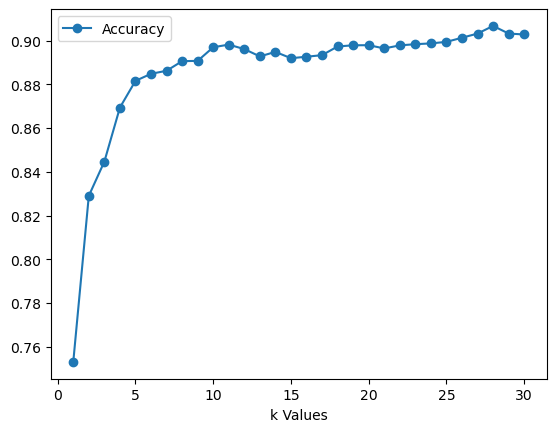

Best k value: 28


In [4]:
# ---------------------------------------------------------------------------- #
#                                 OPTIMIZATION                                 #
# ---------------------------------------------------------------------------- #

# Optimize k values (cross validation)
k_vals = [i for i in range(1,31)]
accs = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_vals:
    temp_model = KNeighborsClassifier(n_neighbors=k)
    acc = cross_val_score(temp_model, X, y, scoring='roc_auc')
    accs.append(np.mean(acc))

plt.xlabel('k Values')
plt.plot(k_vals, accs, 'o-', label='Accuracy')
plt.legend()
plt.show()

# Find best k value
best_k = k_vals[np.argmax(accs)]

print(f'Best k value: {best_k}')

In [5]:
# Create optimized model
model = KNeighborsClassifier(n_neighbors=best_k)

# Train optimized model
model.fit(train_X, train_y)

# Test optimized model
y_pred = model.predict(test_X)
pred_probs = model.predict_proba(test_X)

# Evaluation
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.75
AUC-ROC: 0.89


<hr>

## Radius Neighbors Classifier (RNC)

RNC is similar to k-NN but classifies data points based on neighbors within a specified radius rather than a fixed number of neighbors. This method adapts well to varying data densities by focusing on the local context.

RNC is useful when the density of the dataset varies, allowing it to handle areas with sparse data more effectively than k-NN. However, choosing the appropriate radius can be challenging, and the method might struggle if no neighbors fall within the radius for certain test samples, leading to potential outlier classification issues.

In [6]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = RadiusNeighborsClassifier(radius=1, outlier_label=0)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)
pred_probs = model.predict_proba(test_X)

# Evaluation
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.55
AUC-ROC: 0.50


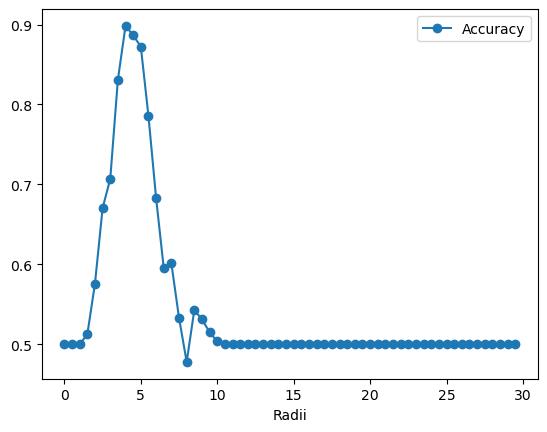

Best radius: 4.0


In [7]:
# ---------------------------------------------------------------------------- #
#                                 OPTIMIZATION                                 #
# ---------------------------------------------------------------------------- #

# Optimize radii (cross validation)
radii = np.arange(0,30,.5)
accs = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for rad in radii:
    temp_model = RadiusNeighborsClassifier(radius=rad, outlier_label=0)
    acc = cross_val_score(temp_model, X, y, scoring='roc_auc')
    accs.append(np.mean(acc))

plt.xlabel('Radii')
plt.plot(radii, accs, 'o-', label='Accuracy')
plt.legend()
plt.show()

# Find best k value
best_radius = radii[np.argmax(accs)]

print(f'Best radius: {best_radius}')

In [8]:
# Create optimized model
model = RadiusNeighborsClassifier(radius=best_radius, outlier_label=0)

# Train optimized model
model.fit(train_X, train_y)

# Test optimized model
y_pred = model.predict(test_X)
pred_probs = model.predict_proba(test_X)

# Evaluation
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.75
AUC-ROC: 0.82


### References:

* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html